In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score)
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet101
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from skimage import io
from keras.preprocessing import image

In [3]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

## Data

In [4]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/drive/MyDrive/03_March/Btech_cv19/log_data/'
train_dir = os.path.join(data_dir)

In [5]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/305.png,0,COVID
1,COVID/307.png,0,COVID
2,COVID/304.png,0,COVID
3,COVID/302.png,0,COVID
4,COVID/300.png,0,COVID


## Randomize the order of training set

In [6]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,non-COVID/1.png,1,non-COVID
1,non-COVID/988.png,1,non-COVID
2,COVID/499.png,0,COVID
3,non-COVID/328.png,1,non-COVID
4,COVID/1066.png,0,COVID


## Plot a histogram

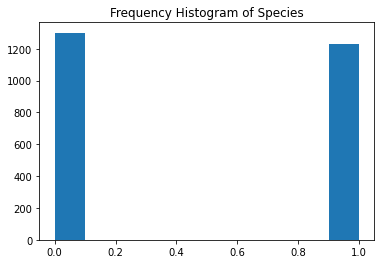

<Figure size 864x864 with 0 Axes>

In [7]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

## Display images of COVID

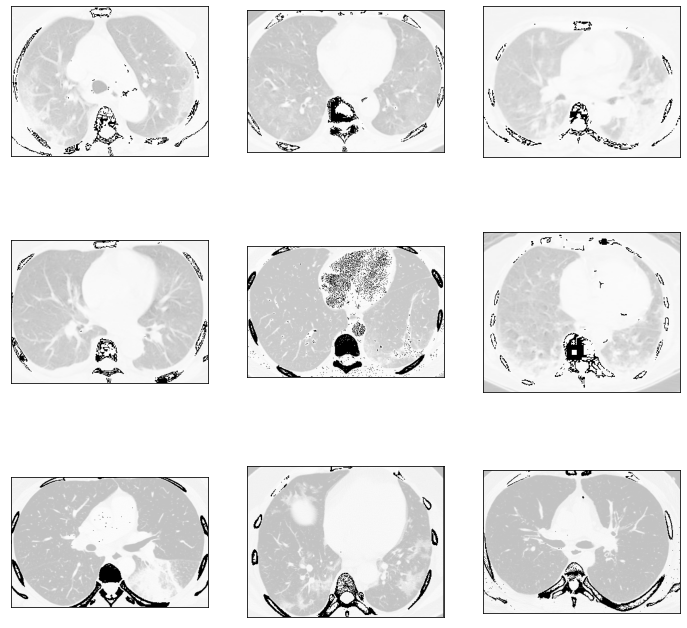

In [8]:
plot_defects('COVID', 3, 3)

## Display images of non-COVID

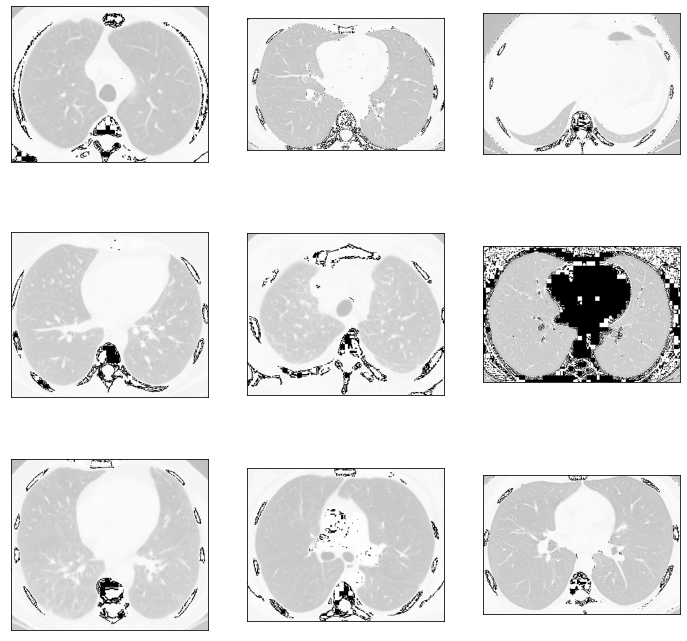

In [9]:
plot_defects('non-COVID', 3, 3)

## Image Read and Resize


In [10]:
IMAGE_SIZE = 128
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

## Data Augmnetation

In [11]:
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

## Training Images

In [12]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2530it [04:28,  9.44it/s]


Train Shape: (2530, 128, 128, 3)


## Converting Labels to Categorical

In [13]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

## Train Test Splitting

In [14]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

## 128*128 training images

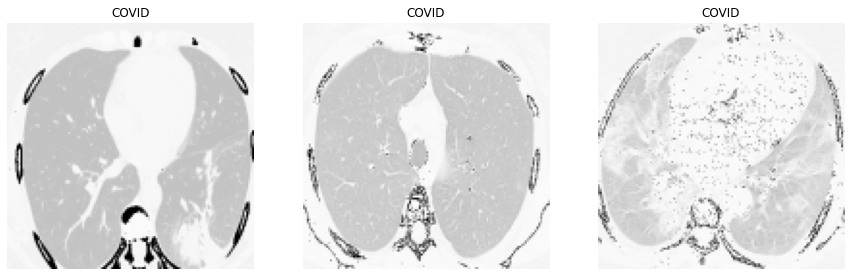

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [16]:
EPOCHS = 100
SIZE=128
N_ch=3

## DenseNet121 Model

In [17]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

## ResNet 101 Model

In [18]:
def build_resnet():
    densenet = ResNet101(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

## Fitting Model DenseNet121 and ResNet101

In [19]:
# model = build_densenet()

In [20]:
model = build_resnet()

171458560/171446536 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 3)       84        
                                                                 
 resnet101 (Functional)      (None, None, None, 2048)  42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=2, learning_rate =1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)


datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.69973, saving model to model.h5
31/31 - 47s - loss: 1.2005 - accuracy: 0.5342 - val_loss: 0.6997 - val_accuracy: 0.5020 - lr: 0.0020 - 47s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 0.69973
31/31 - 13s - loss: 0.9469 - accuracy: 0.6276 - val_loss: 2.7712 - val_accuracy: 0.4842 - lr: 0.0020 - 13s/epoch - 435ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.69973
31/31 - 13s - loss: 0.8003 - accuracy: 0.6867 - val_loss: 3.3147 - val_accuracy: 0.5158 - lr: 0.0020 - 13s/epoch - 435ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.69973
31/31 - 14s - loss: 0.7196 - accuracy: 0.7240 - val_loss: 1.7947 - val_accuracy: 0.4842 - lr: 0.0020 - 14s/epoch - 440ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.69973
31/31 - 14s - loss: 0.6439 - accuracy: 0.7485 - val_loss: 29.4912 - val_accuracy: 0.5158 - lr: 0.0020 - 14s/epoch - 451ms/step
Epoch 6/100

Epoch 6: val_loss did not improve

## Final Loss and Accuracy

In [22]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 1s 74ms/step - loss: 0.2402 - accuracy: 0.8953
Final Loss: 0.240164652466774, Final Accuracy: 0.8952569365501404


## Confusion Matrix

Text(0.5, 145.31999999999996, 'Predicted')

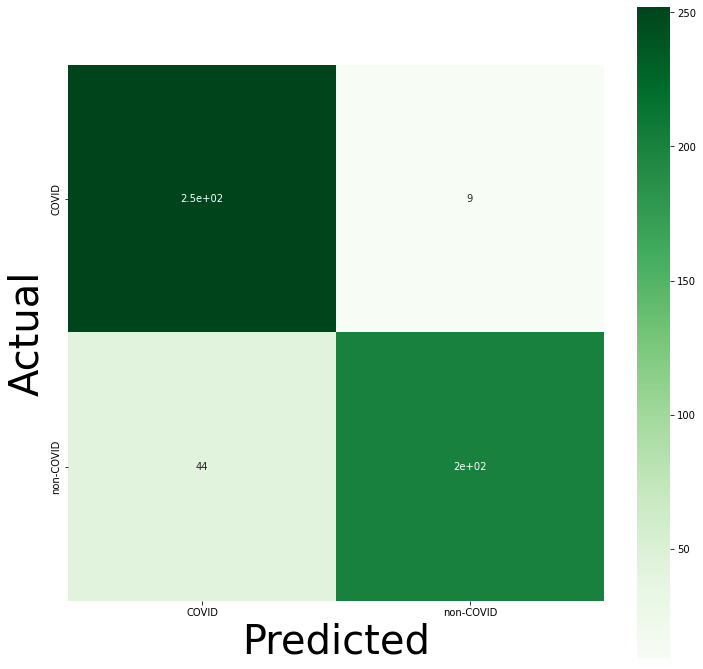

In [23]:
Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90       261
           1       0.96      0.82      0.88       245

    accuracy                           0.90       506
   macro avg       0.90      0.89      0.89       506
weighted avg       0.90      0.90      0.89       506



## Accuracy and Loss Curve

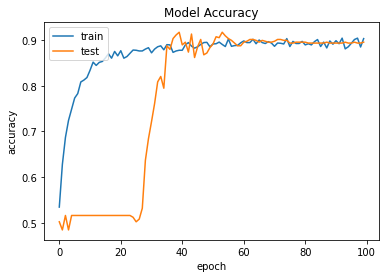

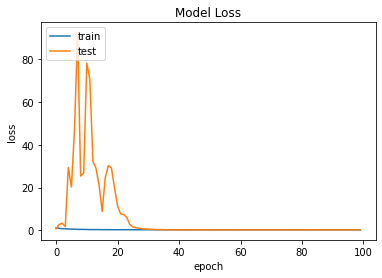

In [25]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction from Image

In [30]:
# Read Image
img = image.load_img('/content/drive/MyDrive/03_March/Btech_cv19/log_data/COVID/a.png', grayscale=False, target_size=(64, 64))
show_img = image.load_img('/content/drive/MyDrive/03_March/Btech_cv19/log_data/COVID/1.png', grayscale=False, target_size=(200, 200))

AttributeError: ignored

In [ ]:
# Preprocess image for prediction 
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

In [ ]:
# Predict Image
custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])